In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import lseg.data as ld
from lseg.data.discovery import Chain
from lseg.data.content import esg
import seaborn as sns


# Portfolio Selection

C:\Users\MasseiM\AppData\Local\Temp\ipykernel_28320\3003240736.py:55:FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


[SCREEN] present by 2015-06-01: 425
[SCREEN] kept (coverage ≥ 100%): 425
[SCREEN] dropped: 0
[SCREEN] panel range: 2015-06-02 → 2025-05-30


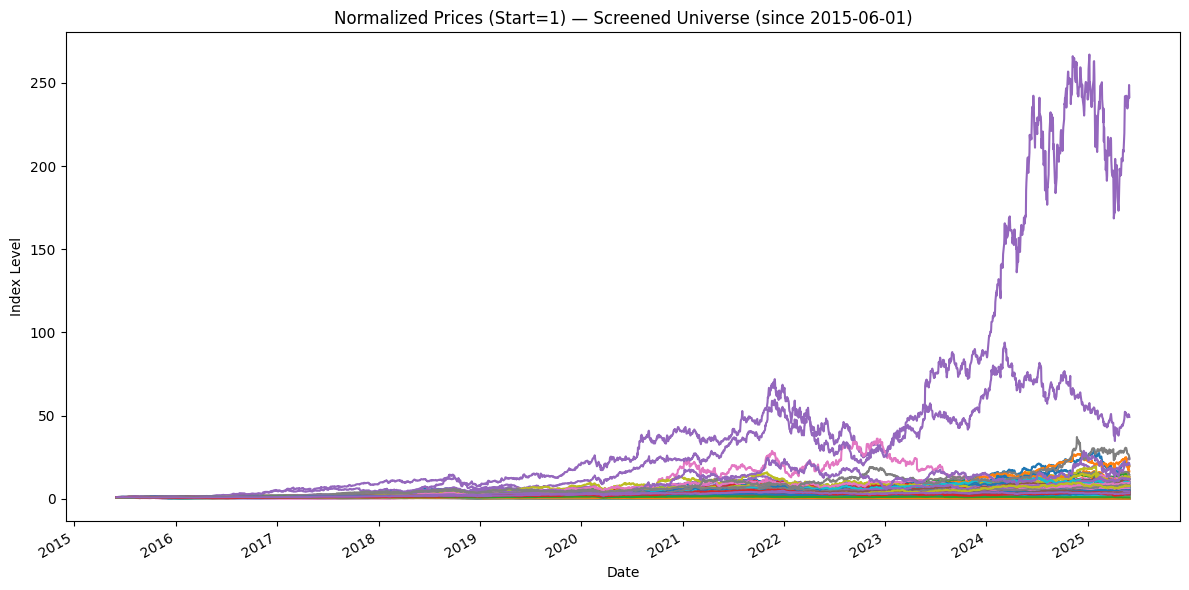

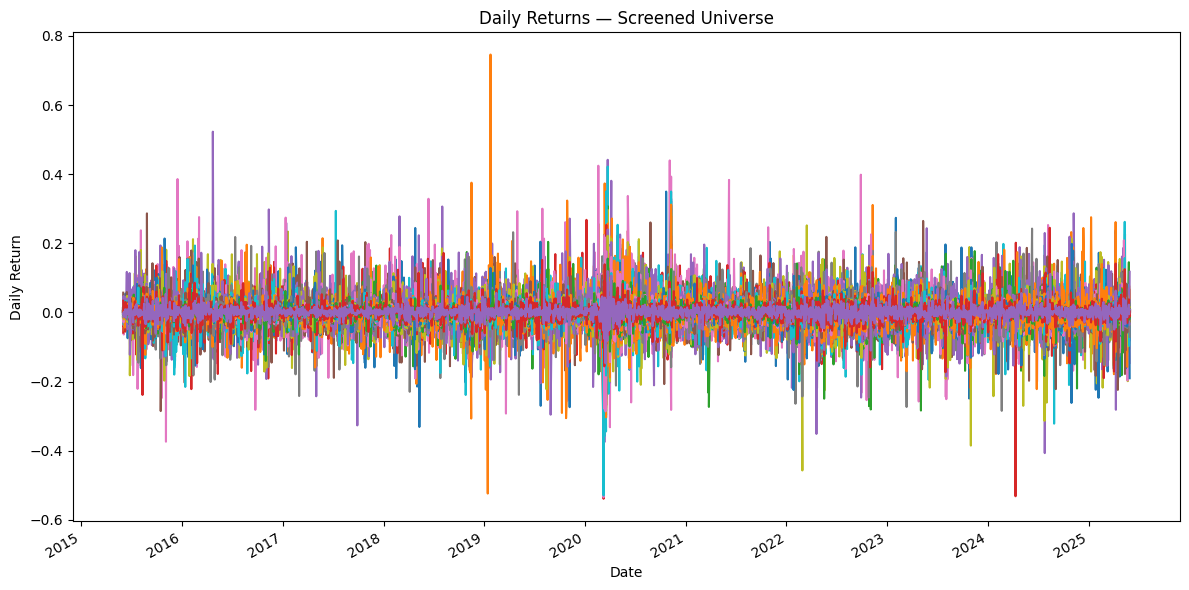

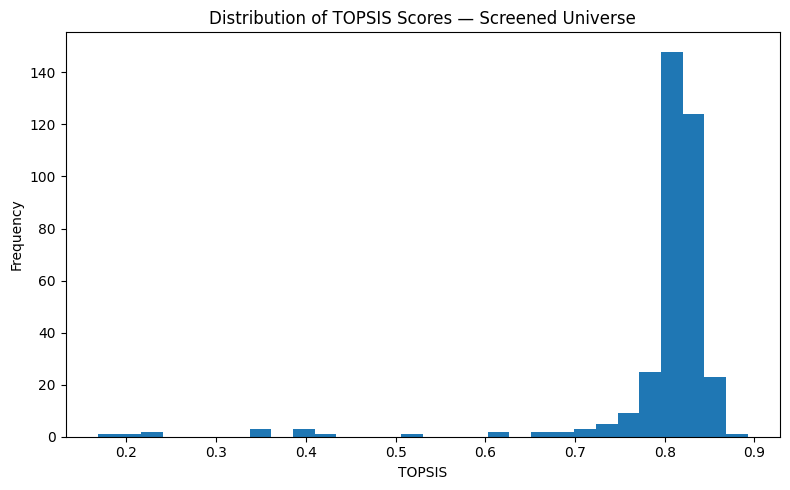

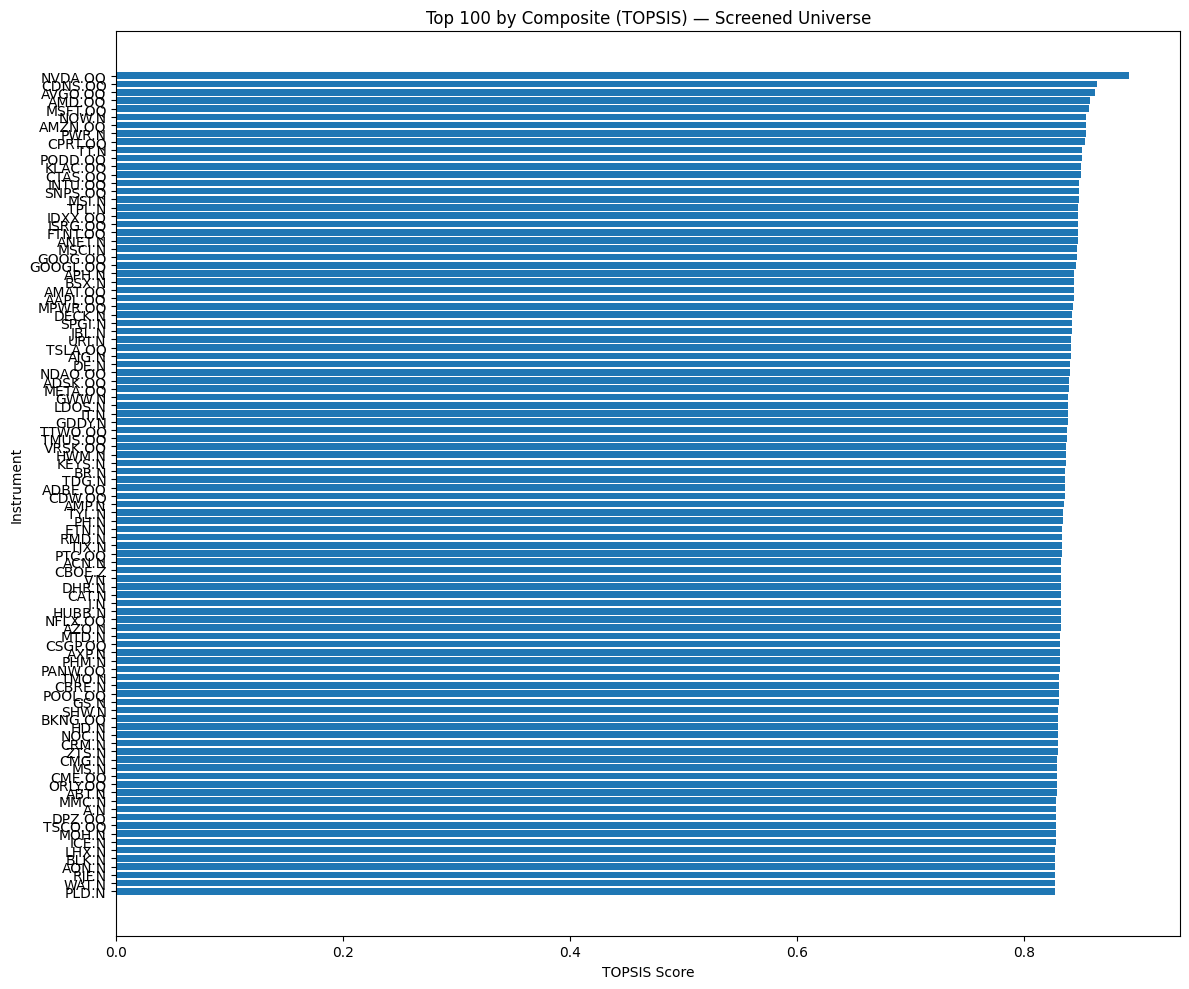

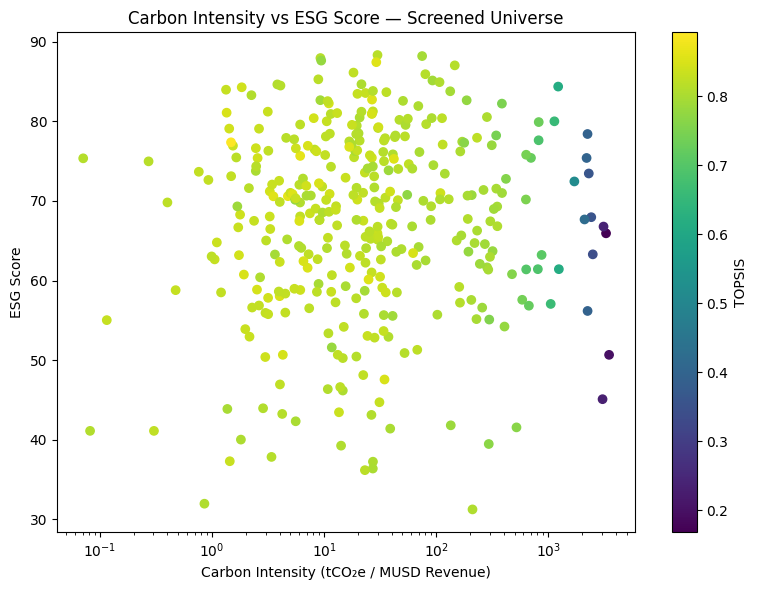

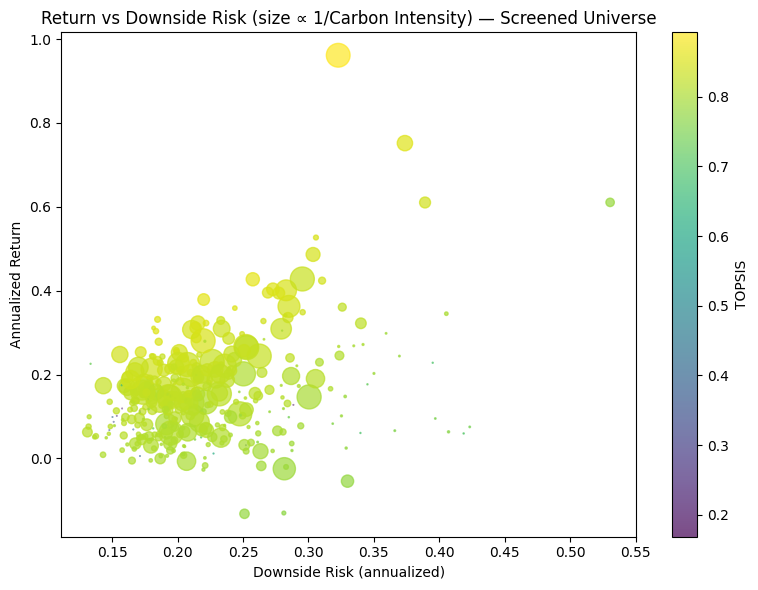

Saved: all_scores_TOPSIS.csv
Saved: top100_scores_TOPSIS.csv
Kept list: screen_kept_since2015.csv
Dropped list: screen_dropped_since2015.csv


In [30]:
# topsis_full_pipeline_strict_revenue.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
DATA_DIR    = ""  # change if needed
FUND_FILE   = os.path.join(DATA_DIR, "fundamentals_esg_snapshot.csv")
CARBON_FILE = os.path.join(DATA_DIR, "spx500_carbon_emissions_snapshots.csv")
PRICES_FILE = os.path.join(DATA_DIR, "prices.csv")

# TOPSIS weights: [CarbonIntensity, ESG, Return, DownsideRisk]
WEIGHTS = np.array([0.30, 0.30, 0.10, 0.30])

# Universe screen parameters
START_DATE   = pd.Timestamp("2015-06-01")
FFILL_LIMIT  = 10      # forward-fill up to 10 consecutive missing trading days
COVERAGE_MIN = 1.0     # require ≥100% non-missing after START_DATE

TOPK = 100             # we will take up to Top-100 after screening

# =========================
# UTILITIES
# =========================
def vecnorm(arr: np.ndarray) -> np.ndarray:
    """Euclidean (vector) normalization for TOPSIS."""
    denom = np.sqrt(np.nansum(arr**2))
    if denom == 0 or not np.isfinite(denom):
        return np.zeros_like(arr, dtype=float)
    return arr / denom

# =========================
# LOAD DATA
# =========================
assert os.path.exists(FUND_FILE),   f"Missing file: {FUND_FILE}"
assert os.path.exists(CARBON_FILE), f"Missing file: {CARBON_FILE}"
assert os.path.exists(PRICES_FILE), f"Missing file: {PRICES_FILE}"

fundamentals = pd.read_csv(FUND_FILE)
carbon       = pd.read_csv(CARBON_FILE)
prices_raw   = pd.read_csv(PRICES_FILE, parse_dates=["Date"], index_col="Date").sort_index()

# =========================
# UNIVERSE SCREEN (must exist since 2015-06-01)
# =========================
# 1) present by START_DATE
first_valid = prices_raw.apply(lambda s: s.first_valid_index())
present_by_start = set(first_valid.index[first_valid <= START_DATE])

# 2) restrict to those, and allow short gaps via ffill(limit=FFILL_LIMIT)
panel_raw = prices_raw.loc[:, sorted(present_by_start)].copy()
panel_ff  = panel_raw.fillna(method="ffill", limit=FFILL_LIMIT)

# 3) coverage from START_DATE
panel_ff = panel_ff.loc[START_DATE:].copy()
coverage = 1.0 - panel_ff.isna().mean()       # fraction of non-missing rows per asset
keep_cols = coverage[coverage >= COVERAGE_MIN].index.tolist()
drop_cols = sorted(set(panel_ff.columns) - set(keep_cols))

# 4) final price panel and returns
prices = panel_ff.loc[:, keep_cols].dropna()  # drop any rows still containing NaNs
returns = prices.pct_change().dropna()

# 5) report + save lists
os.makedirs(DATA_DIR or ".", exist_ok=True)
pd.Series(keep_cols, name="Instrument").to_csv(os.path.join(DATA_DIR, "screen_kept_since2015.csv"), index=False)
pd.Series(drop_cols, name="Instrument").to_csv(os.path.join(DATA_DIR, "screen_dropped_since2015.csv"), index=False)

print(f"[SCREEN] present by {START_DATE.date()}: {len(present_by_start)}")
print(f"[SCREEN] kept (coverage ≥ {COVERAGE_MIN:.0%}): {len(keep_cols)}")
print(f"[SCREEN] dropped: {len(drop_cols)}")
print(f"[SCREEN] panel range: {returns.index.min().date()} → {returns.index.max().date()}")

# =========================
# ALIGN FUNDAMENTALS + CARBON TO THE SCREENED UNIVERSE
# =========================
universe = set(prices.columns)
fundamentals = fundamentals[fundamentals["Instrument"].isin(universe)].copy()
carbon       = carbon[carbon["Instrument"].isin(universe)].copy()

# Coerce numeric
for c in ["Revenue", "EBIT", "ESG Score"]:
    if c in fundamentals.columns:
        fundamentals[c] = pd.to_numeric(fundamentals[c], errors="coerce")

carbon_col = "CO2 Equivalent Emissions Total"
if carbon_col not in carbon.columns:
    raise ValueError(f"Carbon file must contain '{carbon_col}'")
carbon[carbon_col] = pd.to_numeric(carbon[carbon_col], errors="coerce")

# =========================
# PRICES → PLOTS (on screened universe)
# =========================
normalized = prices / prices.iloc[0]
fig, ax = plt.subplots(figsize=(12, 6))
normalized.plot(ax=ax, legend=False)
ax.set_title("Normalized Prices (Start=1) — Screened Universe (since 2015-06-01)")
ax.set_xlabel("Date"); ax.set_ylabel("Index Level")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
returns.plot(ax=ax, legend=False)
ax.set_title("Daily Returns — Screened Universe")
ax.set_xlabel("Date"); ax.set_ylabel("Daily Return")
plt.tight_layout(); plt.show()

# =========================
# PERFORMANCE METRICS (on screened universe)
# =========================
avg_daily_ret = returns.mean(skipna=True)
ann_return = (1 + avg_daily_ret).pow(252) - 1

neg = returns.copy()
neg[neg > 0] = 0.0
downside_dev = np.sqrt((neg ** 2).mean()) * np.sqrt(252)

perf = pd.DataFrame({
    "Instrument": ann_return.index,
    "AnnReturn": ann_return.values,
    "DownsideRisk": downside_dev.reindex(ann_return.index).values
})

# =========================
# FUNDAMENTALS + CARBON (STRICT: drop missing/zero revenue)
# =========================
fund = fundamentals.merge(carbon[["Instrument", carbon_col]], on="Instrument", how="inner")
fund["Revenue"] = pd.to_numeric(fund["Revenue"], errors="coerce")
fund = fund.replace({"Revenue": {0: np.nan}}).dropna(subset=["Revenue"])

fund["CarbonIntensity"] = fund[carbon_col] / (fund["Revenue"] / 1000000)  # tCO2e per MUSD
fund["ESG"] = fund["ESG Score"]

# Merge with performance; drop incomplete rows
data = fund.merge(perf, on="Instrument", how="inner").dropna(
    subset=["CarbonIntensity", "ESG", "AnnReturn", "DownsideRisk"]
).copy()

# =========================
# TOPSIS (Euclidean normalization)
# =========================
Z = pd.DataFrame(index=data.index)
Z["LowCarbon"]   = vecnorm(-data["CarbonIntensity"].values)  # smaller = better
Z["ESG"]         = vecnorm( data["ESG"].values)              # larger = better
Z["Return"]      = vecnorm( data["AnnReturn"].values)        # larger = better
Z["LowDownside"] = vecnorm(-data["DownsideRisk"].values)     # smaller = better

# Weighted normalized decision matrix
V = Z.values * WEIGHTS

# Ideal best and worst
ideal_best, ideal_worst = V.max(axis=0), V.min(axis=0)

# Distances
d_plus  = np.linalg.norm(V - ideal_best, axis=1)
d_minus = np.linalg.norm(V - ideal_worst, axis=1)

# Closeness coefficient
cc = d_minus / (d_plus + d_minus)

data["TOPSIS"] = cc
data["Rank"]   = data["TOPSIS"].rank(ascending=False, method="min")

# Take up to Top-100 (may be fewer if the screen leaves <100)
topN = min(TOPK, len(data))
topk_df = data.sort_values("TOPSIS", ascending=False).head(topN).copy()

# =========================
# PLOTS FOR SCORES
# =========================
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(data["TOPSIS"], bins=30)
ax.set_title("Distribution of TOPSIS Scores — Screened Universe")
ax.set_xlabel("TOPSIS"); ax.set_ylabel("Frequency")
plt.tight_layout(); plt.show()

topk_sorted = topk_df.sort_values("TOPSIS", ascending=True)
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(topk_sorted["Instrument"], topk_sorted["TOPSIS"])
ax.set_title(f"Top {topN} by Composite (TOPSIS) — Screened Universe")
ax.set_xlabel("TOPSIS Score"); ax.set_ylabel("Instrument")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(data["CarbonIntensity"], data["ESG"], c=data["TOPSIS"], marker="o")
ax.set_title("Carbon Intensity vs ESG Score — Screened Universe")
ax.set_xlabel("Carbon Intensity (tCO₂e / MUSD Revenue)")
ax.set_ylabel("ESG Score")

# 🔧 log scale on X
ax.set_xscale("log")

plt.colorbar(sc, ax=ax, label="TOPSIS")
plt.tight_layout(); plt.show()


inv_ci = 1 / data["CarbonIntensity"].replace(0, np.nan)
inv_ci = inv_ci.fillna(inv_ci.median())
sizes = 300 * (inv_ci / inv_ci.quantile(0.95)).clip(upper=1)

fig, ax = plt.subplots(figsize=(8, 6))
sc2 = ax.scatter(data["DownsideRisk"], data["AnnReturn"], c=data["TOPSIS"], s=sizes, alpha=0.7, marker="o")
ax.set_title("Return vs Downside Risk (size ∝ 1/Carbon Intensity) — Screened Universe")
ax.set_xlabel("Downside Risk (annualized)")
ax.set_ylabel("Annualized Return")
plt.colorbar(sc2, ax=ax, label="TOPSIS")
plt.tight_layout(); plt.show()

# =========================
# SAVE OUTPUTS
# =========================
out_all = os.path.join(DATA_DIR, "all_scores_TOPSIS.csv")
out_top = os.path.join(DATA_DIR, "top100_scores_TOPSIS.csv")
cols_out = ["Instrument", "CarbonIntensity", "ESG", "AnnReturn", "DownsideRisk", "TOPSIS", "Rank"]
data[cols_out].sort_values("TOPSIS", ascending=False).to_csv(out_all, index=False)
topk_df[cols_out].sort_values("TOPSIS", ascending=False).to_csv(out_top, index=False)

print("Saved:", out_all)
print("Saved:", out_top)
print("Kept list:", os.path.join(DATA_DIR, "screen_kept_since2015.csv"))
print("Dropped list:", os.path.join(DATA_DIR, "screen_dropped_since2015.csv"))


# Portfolio Optimization

## Mean - Variance

C:\Users\MasseiM\AppData\Local\Temp\ipykernel_28320\1261576500.py:34:FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


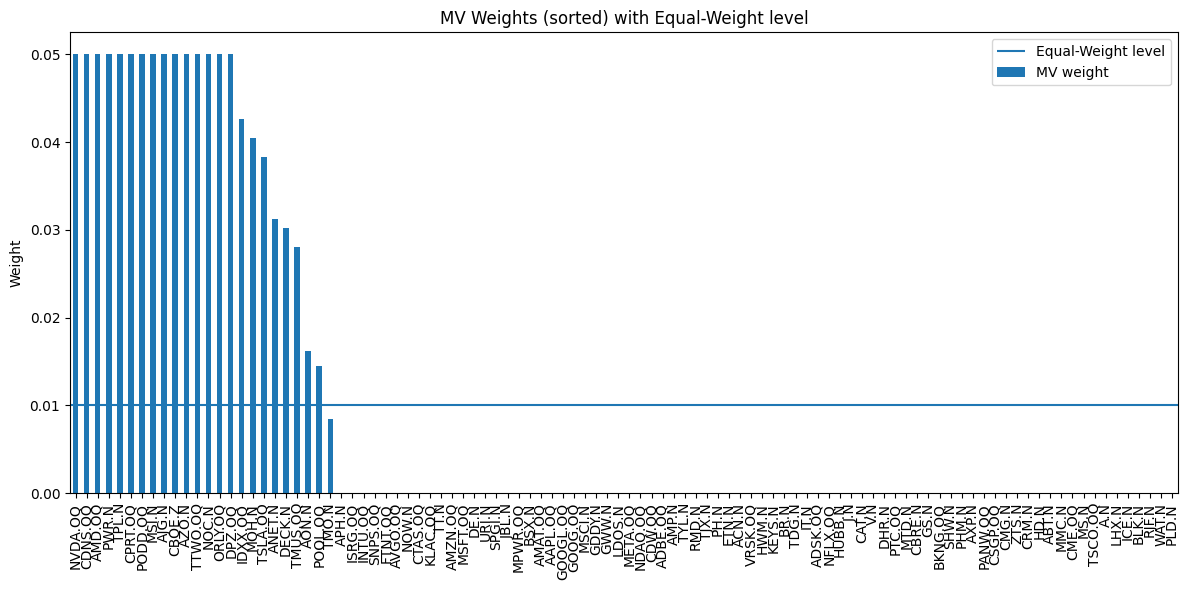

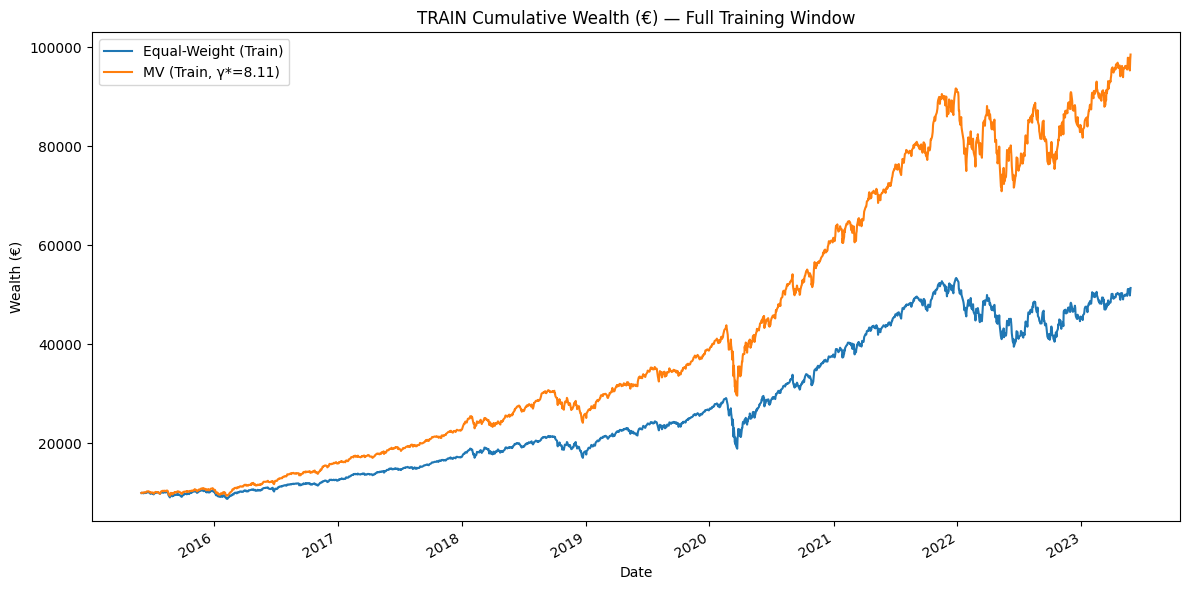

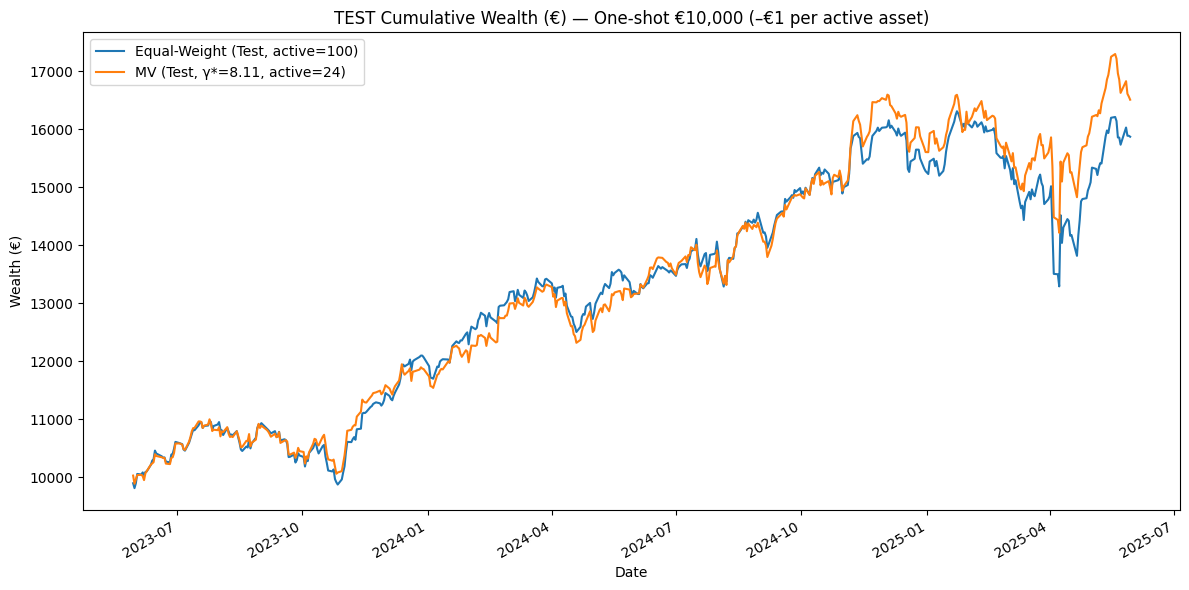

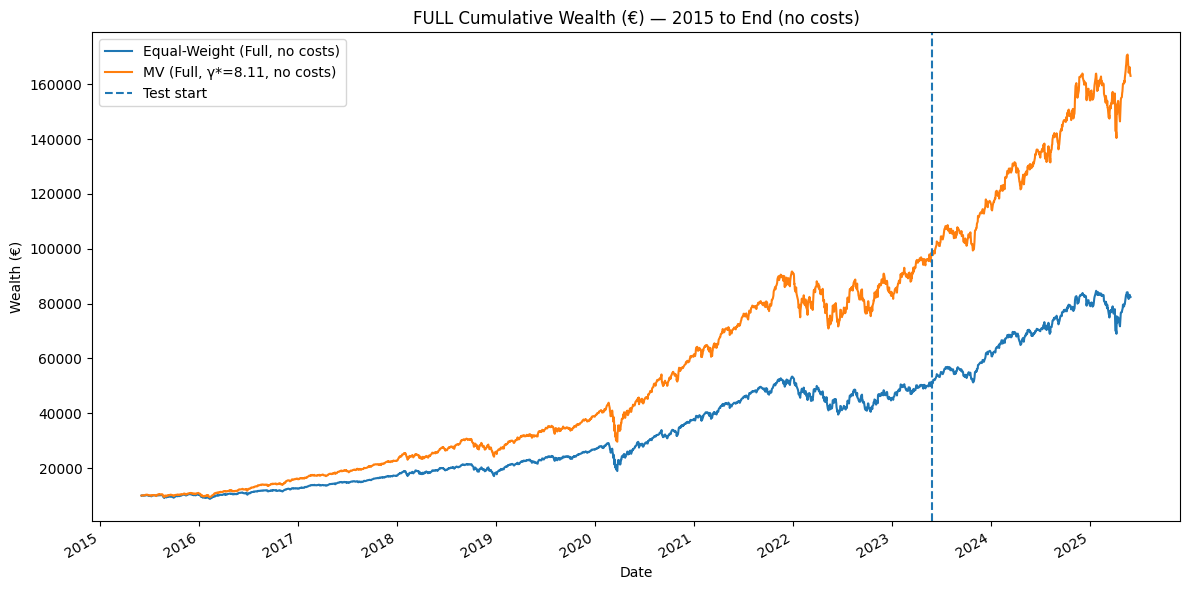

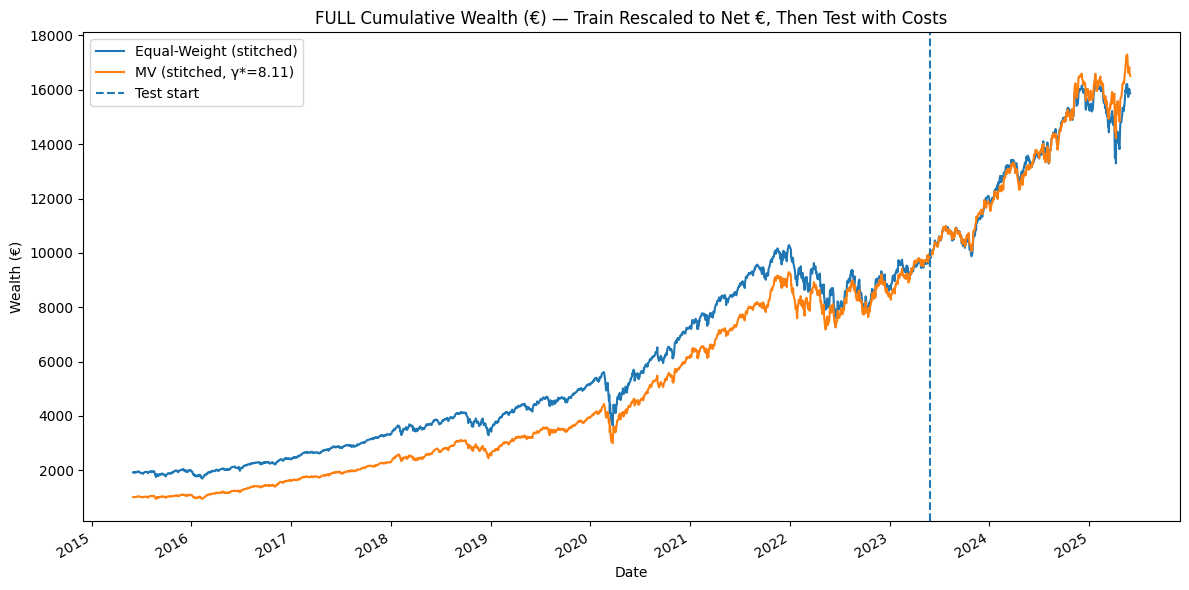

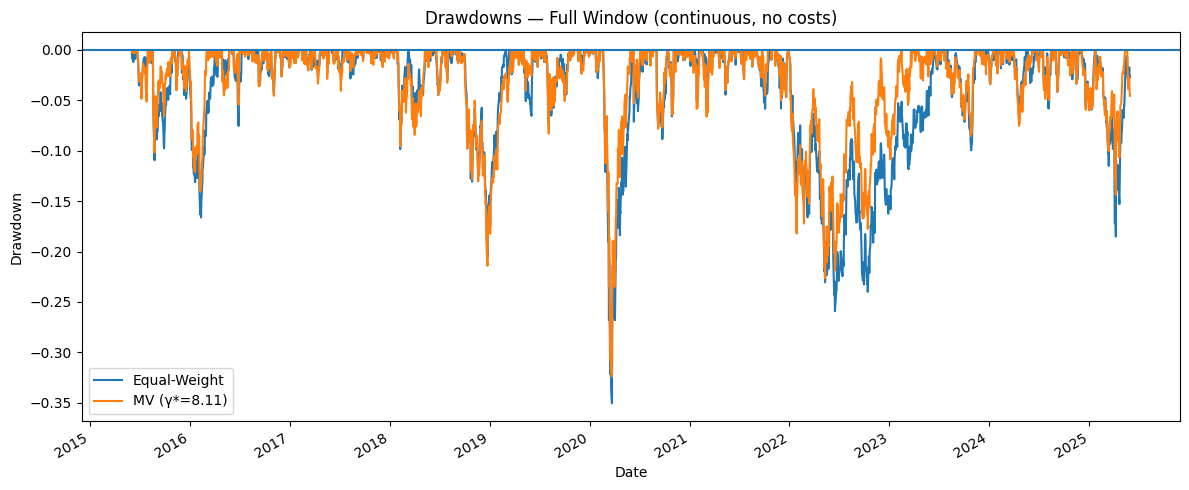

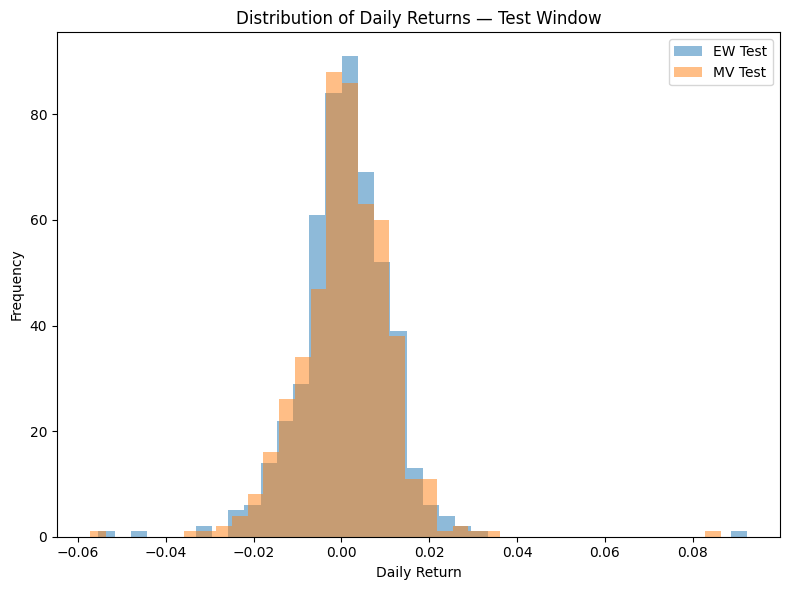

,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.227430,0.210823,1.078771,-0.350545
Mean-Variance,0.308245,0.207109,1.488324,-0.324150


,ActiveAssets,UpfrontCost(€),InitialNet(€),FinalWealth(€),Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,,,,,
Equal-Weight,100,100.000000,9900.000000,15870.147653,0.250618,0.168403,1.488206,-0.185132
Mean-Variance,24,24.000000,9976.000000,16508.366388,0.266413,0.167505,1.590475,-0.143487


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.232068,0.203019,1.143082,-0.350545
Mean-Variance,0.299879,0.199789,1.500976,-0.324150


Mean-Variance Optimal Weights (γ*=8.11)


,Instrument,Weight
0,NVDA.OQ,0.050000
1,CDNS.OQ,0.050000
3,AMD.OQ,0.050000
7,PWR.N,0.050000
16,TPL.N,0.050000
8,CPRT.OQ,0.050000
10,PODD.OQ,0.050000
15,MSI.N,0.050000
34,AJG.N,0.050000
60,CBOE.Z,0.050000


Gamma*: 8.111 | Active MV names: 24 | Summary: mv_full_report_summary_top100.csv | Weights: mv_weights_train_gamma_star_top100.csv


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# =========================
# CONFIG
# =========================
DATA_DIR = ""
PRICES_FILE = os.path.join(DATA_DIR, "prices.csv")
TOP100_CANDIDATES = [
    "top100_scores_z_strict_revenue.csv",
    "top100_scores_TOPSIS.csv",
    "top100_scores_z.csv",
]

CAP_PER_ASSET   = 0.05        # 5% cap (Top-100)
INITIAL_WEALTH  = 10_000.0
ASSET_FIXED_COST = 1.0        # €1 per active asset

# =========================
# LOAD
# =========================
top100_file = next((os.path.join(DATA_DIR, c) for c in TOP100_CANDIDATES
                    if os.path.exists(os.path.join(DATA_DIR, c))), None)
if top100_file is None:
    raise FileNotFoundError("Top-100 file not found in your DATA_DIR.")

top100   = pd.read_csv(top100_file)
tickers  = top100["Instrument"].tolist()

prices   = pd.read_csv(PRICES_FILE, parse_dates=["Date"], index_col="Date")
prices_100 = prices[tickers].copy().dropna(axis=1, how="all").fillna(method="ffill").dropna()

# Returns
retn = prices_100.pct_change().dropna()
N    = retn.shape[1]

# =========================
# TRAIN / TEST SPLIT
# =========================
if len(retn) >= 2520:
    retn_test  = retn.tail(2*252)
    retn_train = retn.iloc[: -2*252]
else:
    test_len   = max(int(len(retn)*0.2), 252) if len(retn) > 300 else max(int(len(retn)*0.2), 60)
    retn_test  = retn.tail(test_len)
    retn_train = retn.iloc[: -test_len]

# =========================
# ESTIMATE μ, Σ ON TRAIN
# =========================
mu_hat = 252.0 * retn_train.mean().values
Sigma  = 252.0 * retn_train.cov().values
RIDGE  = 1e-6 * np.trace(Sigma) / N if N > 0 else 0.0
Sigma  = 0.5 * (Sigma + Sigma.T) + RIDGE * np.eye(N)

# =========================
# SOLVER: PROJECTED-GRADIENT ON CAPPED SIMPLEX
# =========================
def project_capped_simplex(v, u):
    # Find theta s.t. w = clip(v - theta, 0, u) and sum w = 1
    def f(theta):
        return np.clip(v - theta, 0.0, u).sum() - 1.0
    lo = v.max() - u - 1.0
    hi = v.max()
    for _ in range(60):
        mid = 0.5*(lo+hi)
        if f(mid) > 0: lo = mid
        else: hi = mid
    theta = 0.5*(lo+hi)
    w = np.clip(v - theta, 0.0, u)
    s = w.sum()
    return w/s if s > 0 else np.ones_like(v)/v.size

def solve_mv_pg(mu, Sigma, gamma=3.0, u=0.05, iters=1500, step0=0.25):
    w = np.ones_like(mu)/mu.size
    for t in range(1, iters+1):
        grad = mu - gamma*(Sigma @ w)
        eta  = step0/np.sqrt(t)
        w    = project_capped_simplex(w + eta*grad, u)
    return w

def stats_from_series(r):
    mu  = r.mean()*252.0
    sig = r.std()*np.sqrt(252.0)
    sr  = mu/sig if sig>0 else np.nan
    cum = (1+r).cumprod()
    peak= cum.cummax()
    dd  = (cum/peak - 1.0)
    mdd = dd.min()
    return mu, sig, sr, float(mdd), cum, dd

# =========================
# PICK γ THAT MAXIMIZES TRAIN SHARPE
# =========================
gammas = np.logspace(-2, 2, 12)
best_gamma, best_sr, best_w = None, -np.inf, None
for g in gammas:
    w = solve_mv_pg(mu_hat, Sigma, gamma=g, u=CAP_PER_ASSET, iters=1500, step0=0.25)
    rp_tr = retn_train @ w
    mu_t, sig_t, sr_t, mdd_t, _, _ = stats_from_series(rp_tr)
    if np.isfinite(sr_t) and sr_t > best_sr:
        best_sr, best_gamma, best_w = sr_t, g, w

# Equal-weight
w_eq = np.ones(N)/N

# =========================
# TRAIN METRICS (VIRTUAL €10K, NO COSTS)
# =========================
rp_mv_train = (retn_train @ best_w).rename(f"MV (γ*={best_gamma:.3g})")
rp_eq_train = (retn_train @ w_eq).rename("Equal-Weight")

mu_mv_in, sig_mv_in, sr_mv_in, mdd_mv_in, cum_mv_in, dd_mv_in = stats_from_series(rp_mv_train)
mu_eq_in, sig_eq_in, sr_eq_in, mdd_eq_in, cum_eq_in, dd_eq_in = stats_from_series(rp_eq_train)

wealth_mv_train_eur = INITIAL_WEALTH * cum_mv_in
wealth_eq_train_eur = INITIAL_WEALTH * cum_eq_in

# =========================
# TEST (ONE-SHOT €10K, €1 PER ACTIVE ASSET)
# =========================
active_mv = int(np.sum(best_w > 1e-9))
active_eq = N
W0_mv = INITIAL_WEALTH - active_mv*ASSET_FIXED_COST
W0_eq = INITIAL_WEALTH - active_eq*ASSET_FIXED_COST

rp_mv_test = (retn_test @ best_w).rename(f"MV (γ*={best_gamma:.3g})")
rp_eq_test = (retn_test @ w_eq).rename("Equal-Weight")

mu_mv_out, sig_mv_out, sr_mv_out, mdd_mv_out, cum_mv_out, dd_mv_out = stats_from_series(rp_mv_test)
mu_eq_out, sig_eq_out, sr_eq_out, mdd_eq_out, cum_eq_out, dd_eq_out = stats_from_series(rp_eq_test)

wealth_mv_test_eur = W0_mv * cum_mv_out
wealth_eq_test_eur = W0_eq * cum_eq_out

# =========================
# FULL PERIOD (CONTINUOUS, NO COSTS)
# =========================
rp_mv_full = (retn @ best_w).rename(f"MV (γ*={best_gamma:.3g})")
rp_eq_full = (retn @ w_eq).rename("Equal-Weight")

mu_mv_full, sig_mv_full, sr_mv_full, mdd_mv_full, cum_mv_full, dd_mv_full = stats_from_series(rp_mv_full)
mu_eq_full, sig_eq_full, sr_eq_full, mdd_eq_full, cum_eq_full, dd_eq_full = stats_from_series(rp_eq_full)

wealth_mv_full_eur = INITIAL_WEALTH * cum_mv_full
wealth_eq_full_eur = INITIAL_WEALTH * cum_eq_full

# =========================
# STITCHED SERIES (TRAIN RESCALED TO NET € AT TEST START + OOS WITH COSTS)
# =========================
mv_scale = W0_mv / wealth_mv_train_eur.iloc[-1] if wealth_mv_train_eur.iloc[-1] != 0 else 1.0
ew_scale = W0_eq / wealth_eq_train_eur.iloc[-1] if wealth_eq_train_eur.iloc[-1] != 0 else 1.0

wealth_mv_stitched = pd.concat([wealth_mv_train_eur * mv_scale, wealth_mv_test_eur])
wealth_ew_stitched = pd.concat([wealth_eq_train_eur * ew_scale, wealth_eq_test_eur])

# =========================
# PLOTS (ALWAYS LABELED; MV vs EW TOGETHER)
# =========================
# 1) Weights (sorted) with EW reference
w_ser = pd.Series(best_w, index=prices_100.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 6))
w_ser.plot(kind="bar", ax=ax, label="MV weight")
ax.hlines(1.0/N, -0.5, len(w_ser)-0.5, label="Equal-Weight level")
ax.set_title("MV Weights (sorted) with Equal-Weight level")
ax.set_ylabel("Weight"); ax.legend()
plt.tight_layout(); plt.show()

# 2) TRAIN wealth (virtual 10k, no costs)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_train_eur.rename("Equal-Weight (Train)").plot(ax=ax)
wealth_mv_train_eur.rename(f"MV (Train, γ*={best_gamma:.3g})").plot(ax=ax)
ax.set_title("TRAIN Cumulative Wealth (€) — Full Training Window")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# 3) TEST wealth (one-shot 10k minus €1 per active)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_test_eur.rename(f"Equal-Weight (Test, active={active_eq})").plot(ax=ax)
wealth_mv_test_eur.rename(f"MV (Test, γ*={best_gamma:.3g}, active={active_mv})").plot(ax=ax)
ax.set_title(f"TEST Cumulative Wealth (€) — One-shot €{INITIAL_WEALTH:,.0f} (–€1 per active asset)")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# 4) FULL (continuous, no costs) with test-start marker
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_full_eur.rename("Equal-Weight (Full, no costs)").plot(ax=ax)
wealth_mv_full_eur.rename(f"MV (Full, γ*={best_gamma:.3g}, no costs)").plot(ax=ax)
ax.axvline(retn_test.index[0], linestyle="--", label="Test start")
ax.set_title("FULL Cumulative Wealth (€) — 2015 to End (no costs)")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# 5) FULL (stitched): train rescaled to net €, then OOS with costs
fig, ax = plt.subplots(figsize=(12,6))
wealth_ew_stitched.rename("Equal-Weight (stitched)").plot(ax=ax)
wealth_mv_stitched.rename(f"MV (stitched, γ*={best_gamma:.3g})").plot(ax=ax)
ax.axvline(retn_test.index[0], linestyle="--", label="Test start")
ax.set_title("FULL Cumulative Wealth (€) — Train Rescaled to Net €, Then Test with Costs")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# 6) Drawdowns (full window, no costs)
dd_eq_full = wealth_eq_full_eur / wealth_eq_full_eur.cummax() - 1.0
dd_mv_full = wealth_mv_full_eur / wealth_mv_full_eur.cummax() - 1.0
fig, ax = plt.subplots(figsize=(12,5))
dd_eq_full.rename("Equal-Weight").plot(ax=ax)
dd_mv_full.rename(f"MV (γ*={best_gamma:.3g})").plot(ax=ax)
ax.axhline(0.0)
ax.set_title("Drawdowns — Full Window (continuous, no costs)")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown"); ax.legend()
plt.tight_layout(); plt.show()

# 8) Histogram of test daily returns
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(rp_eq_test, bins=40, alpha=0.5, label="EW Test")
ax.hist(rp_mv_test, bins=40, alpha=0.5, label="MV Test")
ax.set_title("Distribution of Daily Returns — Test Window")
ax.set_xlabel("Daily Return"); ax.set_ylabel("Frequency"); ax.legend()
plt.tight_layout(); plt.show()

# =========================
# TABLES
# =========================
summary_train = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "Ann.Return": [mu_eq_in, mu_mv_in],
    "Ann.Vol":    [sig_eq_in, sig_mv_in],
    "Sharpe":     [sr_eq_in, sr_mv_in],
    "MaxDD":      [mdd_eq_in, mdd_mv_in],
}).set_index("Portfolio")

summary_train.name = "Portfolio – Train"

summary_test = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "ActiveAssets": [N, int(np.sum(best_w>1e-9))],
    "UpfrontCost(€)": [N*ASSET_FIXED_COST, int(np.sum(best_w>1e-9))*ASSET_FIXED_COST],
    "InitialNet(€)": [INITIAL_WEALTH - N*ASSET_FIXED_COST, INITIAL_WEALTH - int(np.sum(best_w>1e-9))*ASSET_FIXED_COST],
    "FinalWealth(€)": [float(wealth_eq_test_eur.iloc[-1]), float(wealth_mv_test_eur.iloc[-1])],
    "Ann.Return": [mu_eq_out, mu_mv_out],
    "Ann.Vol":    [sig_eq_out, sig_mv_out],
    "Sharpe":     [sr_eq_out, sr_mv_out],
    "MaxDD":      [mdd_eq_out, mdd_mv_out],
}).set_index("Portfolio")

summary_full = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "Ann.Return": [mu_eq_full, mu_mv_full],
    "Ann.Vol":    [sig_eq_full, sig_mv_full],
    "Sharpe":     [sr_eq_full, sr_mv_full],
    "MaxDD":      [mdd_eq_full, mdd_mv_full],
}).set_index("Portfolio")

def show(df, title):
    sty = (df.style
             .set_caption(title)
             .set_table_styles([{
                 "selector": "caption",
                 "props": [("caption-side", "top"),
                           ("font-weight", "bold"),
                           ("font-size", "14px"),
                           ("margin-bottom", "8px")]
             }]))
    display(sty)

show(summary_train, "Portfolio — TRAIN (virtual €10k, no costs)")
show(summary_test,  "Portfolio — TEST (one-shot €10k, €1/asset)")
show(summary_full,  "Portfolio — FULL WINDOW (2015→end, no costs)")

# Export combined CSV + weights
combined = (summary_train.add_prefix("Train_")
            .merge(summary_test.add_prefix("Test_"), left_index=True, right_index=True)
            .merge(summary_full.add_prefix("Full_"), left_index=True, right_index=True))
combined.to_csv(os.path.join(DATA_DIR, "mv_full_report_summary_top100.csv"))

pd.DataFrame({"Instrument": w_ser.index, "Weight": w_ser.values}).to_csv(
    os.path.join(DATA_DIR, "mv_weights_train_gamma_star_top100.csv"), index=False
)

# Create DataFrame of weights
mv_weights = pd.DataFrame({
    "Instrument": prices_100.columns,
    "Weight": best_w
}).sort_values("Weight", ascending=False)

# Show non-zero weights only
mv_weights = mv_weights[mv_weights["Weight"] > 1e-6]

# Print nicely
print("Mean-Variance Optimal Weights (γ*={:.3g})".format(best_gamma))
display(mv_weights)

# Optionally save to CSV
mv_weights.to_csv("mv_weights_vector.csv", index=False)


print(f"Gamma*: {best_gamma:.4g} | Active MV names: {int(np.sum(best_w>1e-9))} | "
      f"Summary: mv_full_report_summary_top100.csv | Weights: mv_weights_train_gamma_star_top100.csv")


## CVAR

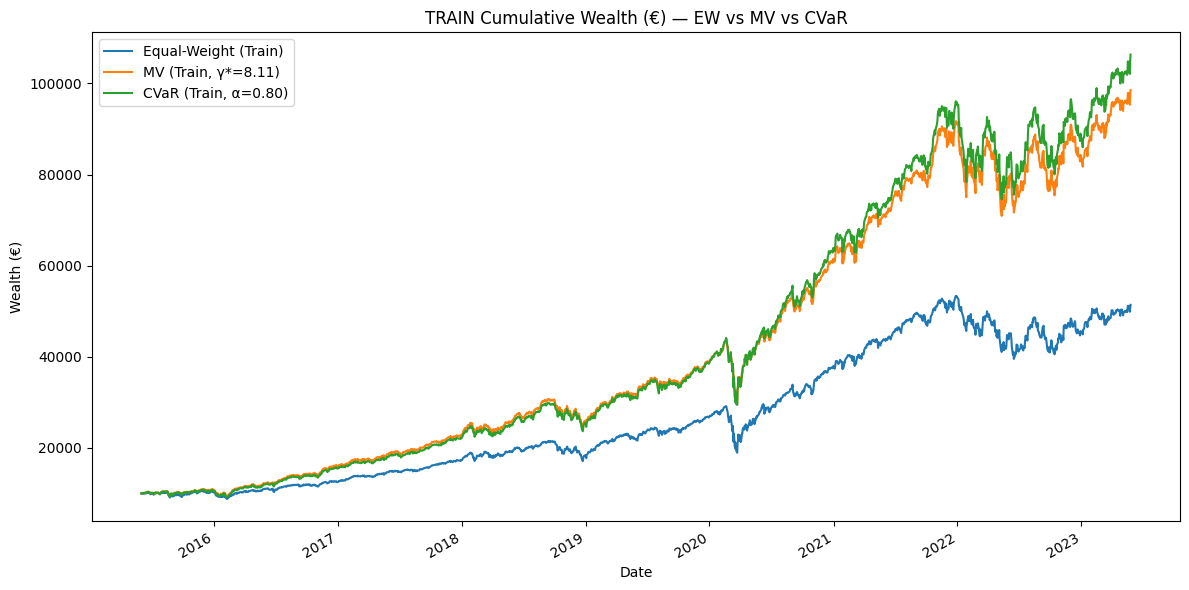

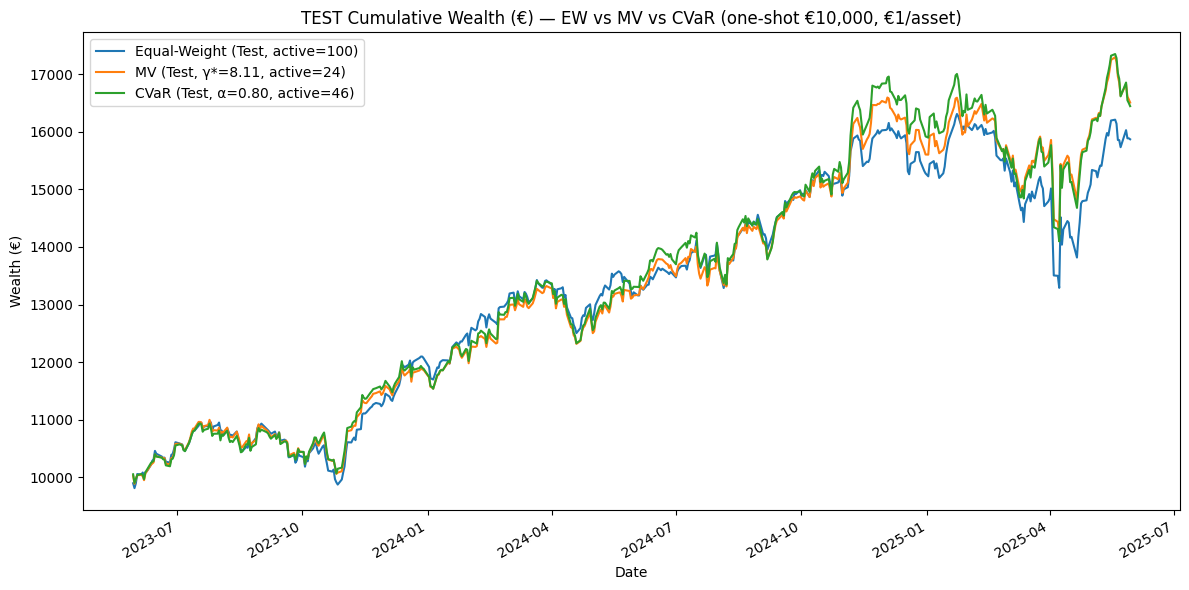

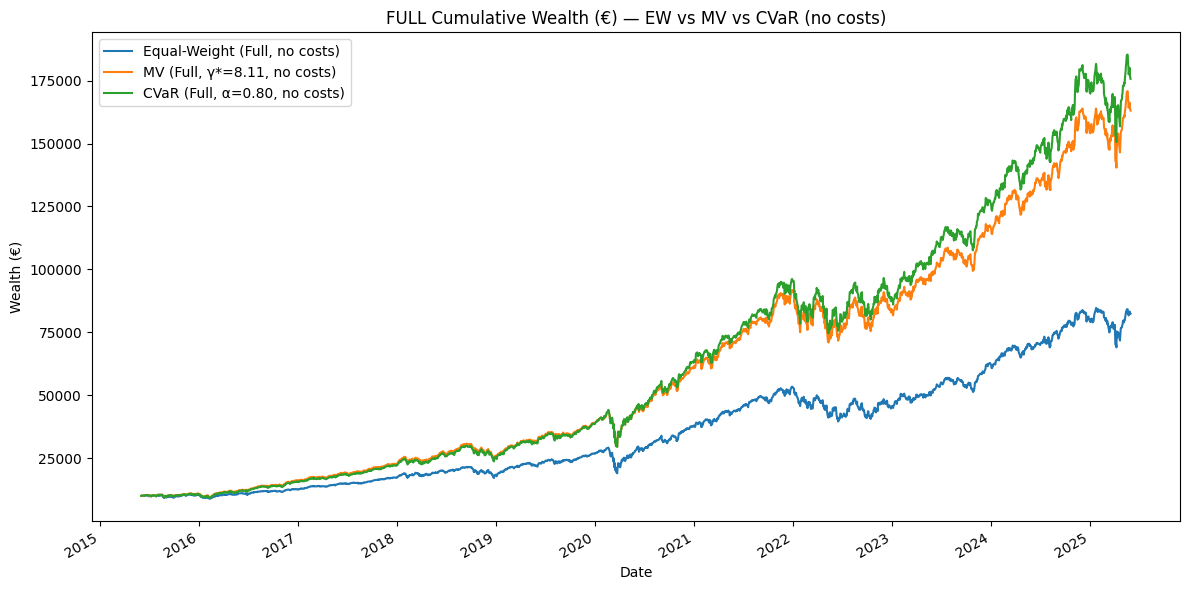

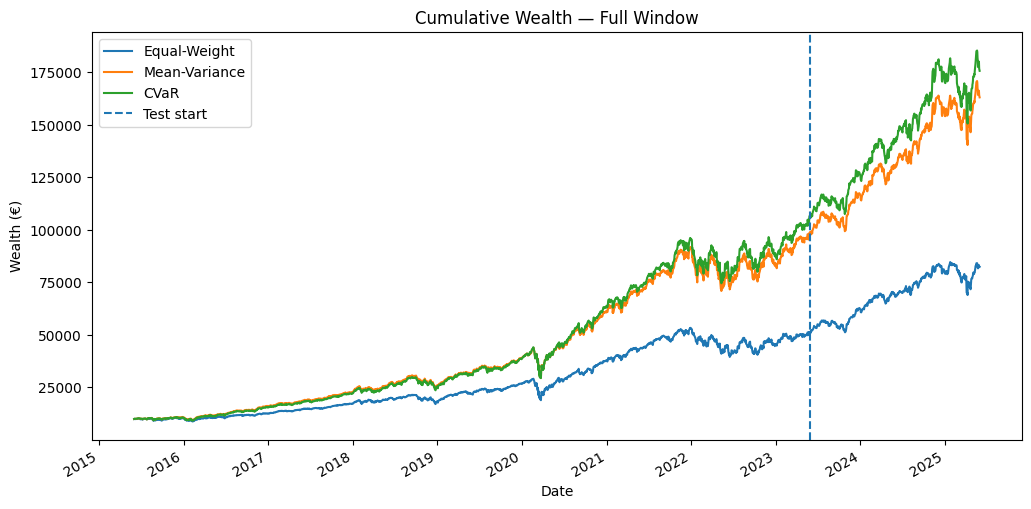

,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.227430,0.210823,1.078771,-0.350545
Mean-Variance,0.308245,0.207109,1.488324,-0.324150
CVaR,0.319377,0.214535,1.488692,-0.333351


,ActiveAssets,UpfrontCost(€),InitialNet(€),FinalWealth(€),Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,,,,,
Equal-Weight,100.000000,100.000000,9900.000000,15870.147653,0.250618,0.168403,1.488206,-0.185132
Mean-Variance,24.000000,24.000000,9976.000000,16508.366388,0.266413,0.167505,1.590475,-0.143487
CVaR,46.000000,46.000000,9954.000000,16445.655765,0.267949,0.181056,1.479924,-0.170956


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.232068,0.203019,1.143082,-0.350545
Mean-Variance,0.299879,0.199789,1.500976,-0.324150
CVaR,0.309091,0.208240,1.484299,-0.333351


CVaR Optimal Weights (α=0.80, τ*=1.2673e-03, active=46)


,Instrument,Weight
86,ORLY.OQ,0.050000
80,NOC.N,0.050000
15,MSI.N,0.050000
8,CPRT.OQ,0.050000
14,SNPS.OQ,0.050000
34,AJG.N,0.050000
67,AZO.N,0.050000
16,TPL.N,0.050000
1,CDNS.OQ,0.050000
10,PODD.OQ,0.049999


In [16]:
# =========================
# CVaR OPTIMIZATION 
# =========================
import cvxpy as cp

ALPHA = 0.80  # CVaR confidence
T = retn_train.shape[0]
R_train = retn_train.values  # T x N matrix
mu_daily = retn_train.mean().values  # N-vector (daily)
mu_ann   = 252.0 * mu_daily

def solve_cvar_min(alpha=ALPHA, target_daily=0.17/252.0, cap=CAP_PER_ASSET):
    """
    Minimize CVaR_alpha subject to E[daily return] >= target_daily,
    sum w = 1, 0 <= w <= cap (long-only, per-asset cap).
    """
    w = cp.Variable(N, nonneg=True)
    z = cp.Variable()          # VaR
    u = cp.Variable(T, nonneg=True)

    # Losses L_t = -r_t^T w
    L = -R_train @ w

    constraints = [
        cp.sum(w) == 1.0,
        w <= cap,
        u >= L - z,            # u_t >= L_t - z
        u >= 0,
        mu_daily @ w >= target_daily

    ]

    obj = z + (1.0/((1.0 - alpha) * T)) * cp.sum(u)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.SCS, verbose=False)  # ECOS/SCS both fine; ECOS faster here

    if w.value is None:
        return None, None
    return w.value, prob.value  # weights, train CVaR objective

# --- Trace frontier by sweeping the return floor (daily) ---
# Grid of daily targets spanning the asset means
low, high = np.quantile(mu_daily, [0.25, 0.90])
targets = np.linspace(low, high, 15)

cvar_weights = []
cvar_stats   = []  # (mu_ann, vol_ann, sharpe, mdd)
for tau in targets:
    sol, val = solve_cvar_min(target_daily=tau, cap=CAP_PER_ASSET)
    if sol is None:
        continue
    w_cvar = sol
    # Train stats
    rp_tr_cvar = retn_train @ w_cvar
    mu_c, sig_c = rp_tr_cvar.mean()*252.0, rp_tr_cvar.std()*np.sqrt(252.0)
    sr_c = (mu_c/sig_c) if sig_c > 0 else np.nan
    # Max drawdown (train)
    cum = (1+rp_tr_cvar).cumprod()
    mdd = (cum/cum.cummax() - 1.0).min()
    cvar_weights.append(w_cvar)
    cvar_stats.append((w_cvar, tau, mu_c, sig_c, sr_c, mdd))

# Pick CVaR portfolio with highest train Sharpe
if len(cvar_stats) == 0:
    raise RuntimeError("CVaR optimizer failed to find feasible solutions. Try relaxing targets or CAP_PER_ASSET.")
w_cvar_star, tau_star, mu_c, sig_c, sr_c, mdd_c = sorted(cvar_stats, key=lambda x: x[4] if np.isfinite(x[4]) else -np.inf)[-1]

# --- TEST wealth in € (one-shot €10k with €1 per active asset) ---
active_cvar = int(np.sum(w_cvar_star > 1e-9))
W0_cvar = INITIAL_WEALTH - active_cvar * ASSET_FIXED_COST

rp_cvar_test = (retn_test @ w_cvar_star).rename(f"CVaR (α={ALPHA:.2f}, τ*={tau_star:.4e})")
wealth_cvar_test_eur = W0_cvar * (1 + rp_cvar_test).cumprod()

# --- TRAIN wealth in € (virtual 10k, no costs) for plotting symmetry ---
rp_cvar_train = (retn_train @ w_cvar_star).rename(f"CVaR (α={ALPHA:.2f})")
wealth_cvar_train_eur = INITIAL_WEALTH * (1 + rp_cvar_train).cumprod()

# --- FULL (continuous, no costs) ---
rp_cvar_full = (retn @ w_cvar_star).rename(f"CVaR (α={ALPHA:.2f})")
wealth_cvar_full_eur = INITIAL_WEALTH * (1 + rp_cvar_full).cumprod()

# --- TEST diagnostics (return/vol/Sharpe/MDD) ---
def _ann_stats(r):
    mu = r.mean()*252.0; vol = r.std()*np.sqrt(252.0)
    sr = mu/vol if vol>0 else np.nan
    dd = ((1+r).cumprod() / (1+r).cumprod().cummax() - 1.0).min()
    return mu, vol, sr, float(dd)

mu_cvar_out, sig_cvar_out, sr_cvar_out, mdd_cvar_out = _ann_stats(rp_cvar_test)
mu_cvar_in,  sig_cvar_in,  sr_cvar_in,  mdd_cvar_in  = _ann_stats(rp_cvar_train)
mu_cvar_full,sig_cvar_full,sr_cvar_full,mdd_cvar_full= _ann_stats(rp_cvar_full)

# =========================
# PLOTS: add CVaR alongside EW & MV
# =========================
# TRAIN (add CVaR curve)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_train_eur.rename("Equal-Weight (Train)").plot(ax=ax)
wealth_mv_train_eur.rename(f"MV (Train, γ*={best_gamma:.3g})").plot(ax=ax)
wealth_cvar_train_eur.rename(f"CVaR (Train, α={ALPHA:.2f})").plot(ax=ax)
ax.set_title("TRAIN Cumulative Wealth (€) — EW vs MV vs CVaR")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# TEST (add CVaR curve)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_test_eur.rename(f"Equal-Weight (Test, active={active_eq})").plot(ax=ax)
wealth_mv_test_eur.rename(f"MV (Test, γ*={best_gamma:.3g}, active={active_mv})").plot(ax=ax)
wealth_cvar_test_eur.rename(f"CVaR (Test, α={ALPHA:.2f}, active={active_cvar})").plot(ax=ax)
ax.set_title(f"TEST Cumulative Wealth (€) — EW vs MV vs CVaR (one-shot €{INITIAL_WEALTH:,.0f}, €1/asset)")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

# FULL (no costs)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_full_eur.rename("Equal-Weight (Full, no costs)").plot(ax=ax)
wealth_mv_full_eur.rename(f"MV (Full, γ*={best_gamma:.3g}, no costs)").plot(ax=ax)
wealth_cvar_full_eur.rename(f"CVaR (Full, α={ALPHA:.2f}, no costs)").plot(ax=ax)
ax.set_title("FULL Cumulative Wealth (€) — EW vs MV vs CVaR (no costs)")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_full_eur.rename("Equal-Weight").plot(ax=ax)
wealth_mv_full_eur.rename("Mean-Variance").plot(ax=ax)
wealth_cvar_full_eur.rename("CVaR").plot(ax=ax)
ax.axvline(retn_test.index[0], linestyle="--", label="Test start")
ax.set_title("Cumulative Wealth — Full Window")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend()
plt.show()


# =========================
# TABLES: append CVaR rows
# =========================
# --- TRAIN ---
summary_train = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "Ann.Return": [mu_eq_in, mu_mv_in],
    "Ann.Vol":    [sig_eq_in, sig_mv_in],
    "Sharpe":     [sr_eq_in, sr_mv_in],
    "MaxDD":      [mdd_eq_in, mdd_mv_in],
}).set_index("Portfolio")

summary_train.loc["CVaR", ["Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    mu_cvar_in, sig_cvar_in, sr_cvar_in, mdd_cvar_in
]

# --- TEST ---
summary_test = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "ActiveAssets": [N, active_mv],
    "UpfrontCost(€)": [N*ASSET_FIXED_COST, active_mv*ASSET_FIXED_COST],
    "InitialNet(€)": [INITIAL_WEALTH - N*ASSET_FIXED_COST,
                      INITIAL_WEALTH - active_mv*ASSET_FIXED_COST],
    "FinalWealth(€)": [float(wealth_eq_test_eur.iloc[-1]),
                       float(wealth_mv_test_eur.iloc[-1])],
    "Ann.Return": [mu_eq_out, mu_mv_out],
    "Ann.Vol":    [sig_eq_out, sig_mv_out],
    "Sharpe":     [sr_eq_out, sr_mv_out],
    "MaxDD":      [mdd_eq_out, mdd_mv_out],
}).set_index("Portfolio")

summary_test.loc["CVaR", ["ActiveAssets","UpfrontCost(€)","InitialNet(€)",
                          "FinalWealth(€)","Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    active_cvar, active_cvar*ASSET_FIXED_COST,
    INITIAL_WEALTH - active_cvar*ASSET_FIXED_COST,
    float(wealth_cvar_test_eur.iloc[-1]),
    mu_cvar_out, sig_cvar_out, sr_cvar_out, mdd_cvar_out
]

# --- FULL ---
summary_full = pd.DataFrame({
    "Portfolio": ["Equal-Weight","Mean-Variance"],
    "Ann.Return": [mu_eq_full, mu_mv_full],
    "Ann.Vol":    [sig_eq_full, sig_mv_full],
    "Sharpe":     [sr_eq_full, sr_mv_full],
    "MaxDD":      [mdd_eq_full, mdd_mv_full],
}).set_index("Portfolio")

summary_full.loc["CVaR", ["Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    mu_cvar_full, sig_cvar_full, sr_cvar_full, mdd_cvar_full
]


# Re-display with captions if you use the helper
show(summary_train, "Portfolio — TRAIN (EW vs MV vs CVaR)")
show(summary_test,  "Portfolio — TEST (EW vs MV vs CVaR)")
show(summary_full,  "Portfolio — FULL WINDOW (EW vs MV vs CVaR)")

# =========================
# WEIGHTS TABLE for CVaR
# =========================
mv_cvar_weights = pd.DataFrame({
    "Instrument": prices_100.columns,
    "Weight": w_cvar_star
}).sort_values("Weight", ascending=False)
mv_cvar_weights = mv_cvar_weights[mv_cvar_weights["Weight"] > 1e-6]

print(f"CVaR Optimal Weights (α={ALPHA:.2f}, τ*={tau_star:.4e}, active={active_cvar})")
display(mv_cvar_weights)
mv_cvar_weights.to_csv("cvar_weights_vector.csv", index=False)


## LSTM - Deep Learning

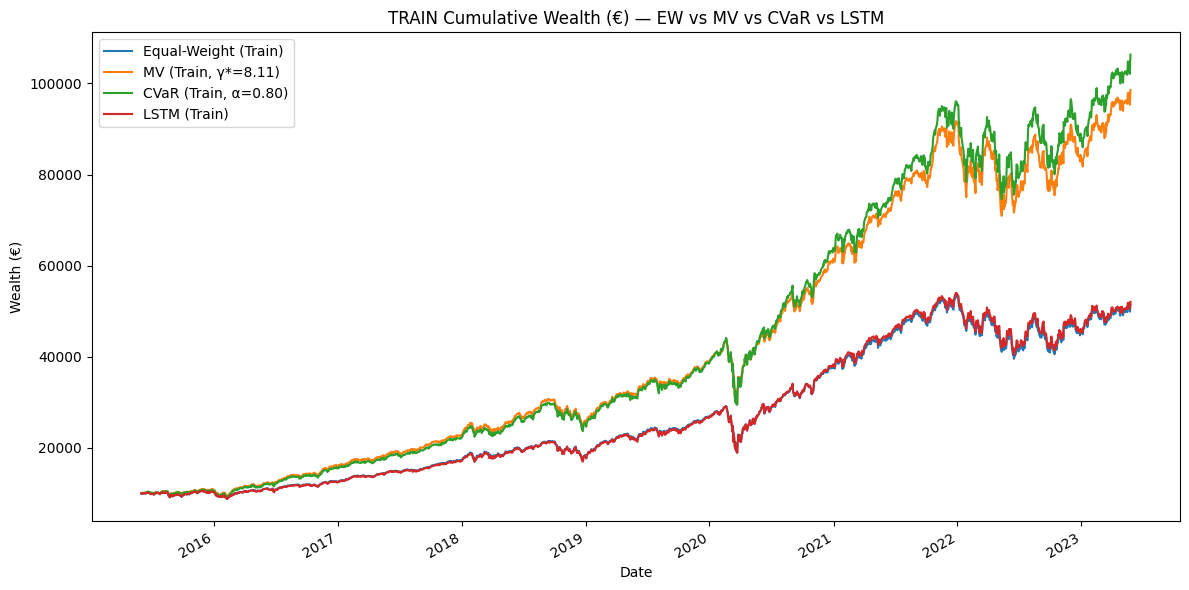

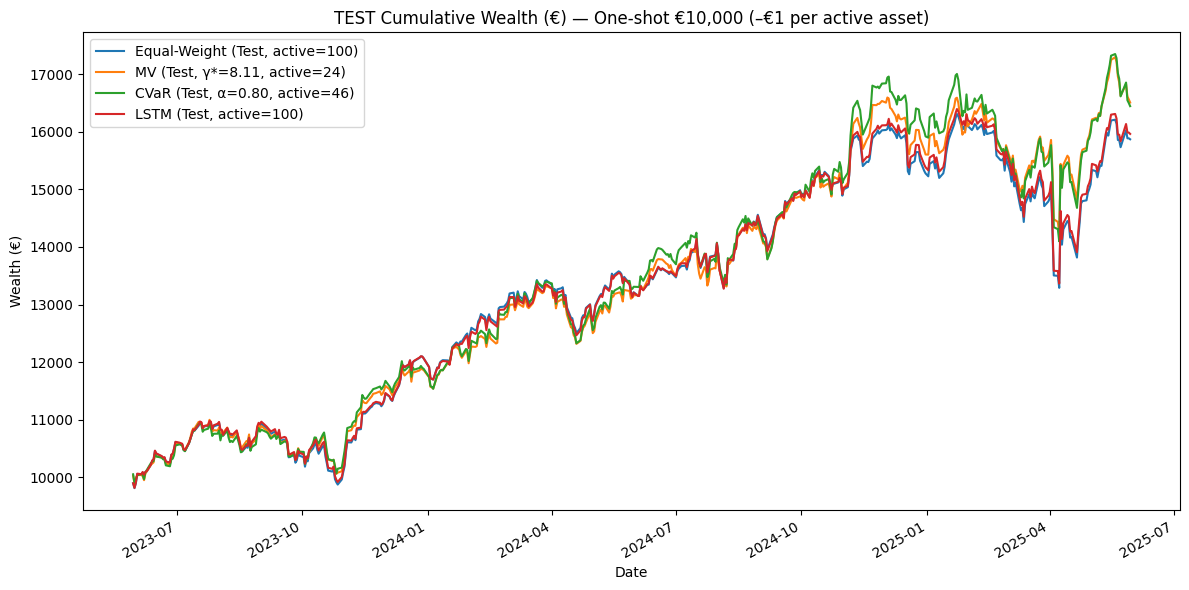

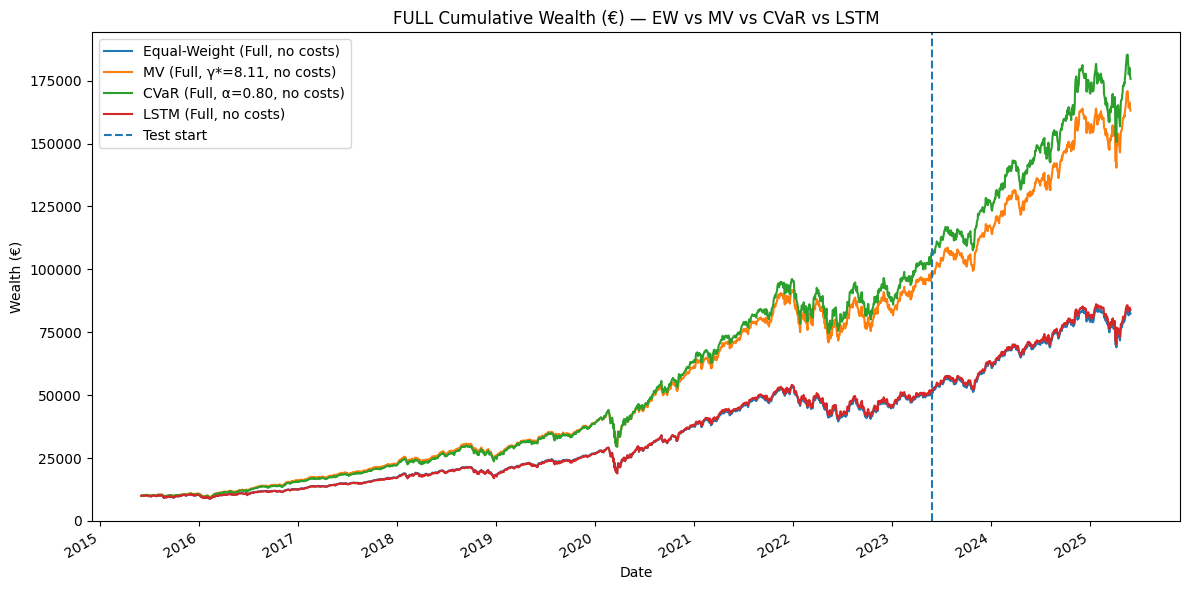

,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.227430,0.210823,1.078771,-0.350545
Mean-Variance,0.308245,0.207109,1.488324,-0.324150
CVaR,0.319377,0.214535,1.488692,-0.333351
LSTM,0.229047,0.211276,1.084117,-0.352075


,ActiveAssets,UpfrontCost(€),InitialNet(€),FinalWealth(€),Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,,,,,
Equal-Weight,100.000000,100.000000,9900.000000,15870.147653,0.250618,0.168403,1.488206,-0.185132
Mean-Variance,24.000000,24.000000,9976.000000,16508.366388,0.266413,0.167505,1.590475,-0.143487
CVaR,46.000000,46.000000,9954.000000,16445.655765,0.267949,0.181056,1.479924,-0.170956
LSTM,100.000000,100.000000,9900.000000,15963.389136,0.253721,0.169404,1.497725,-0.184819


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Portfolio,,,,
Equal-Weight,0.232068,0.203019,1.143082,-0.350545
Mean-Variance,0.299879,0.199789,1.500976,-0.324150
CVaR,0.309091,0.208240,1.484299,-0.333351
LSTM,0.233982,0.203561,1.149444,-0.352075


LSTM One‑shot Weights (active=100)


,Instrument,Weight
61,V.N,0.017295
83,CMG.N,0.017184
16,TPL.N,0.016948
33,TSLA.OQ,0.015476
22,GOOG.OQ,0.014769
...,...,...
86,ORLY.OQ,0.008152
85,CME.OQ,0.008152
93,ICE.N,0.008152
92,MOH.N,0.008152


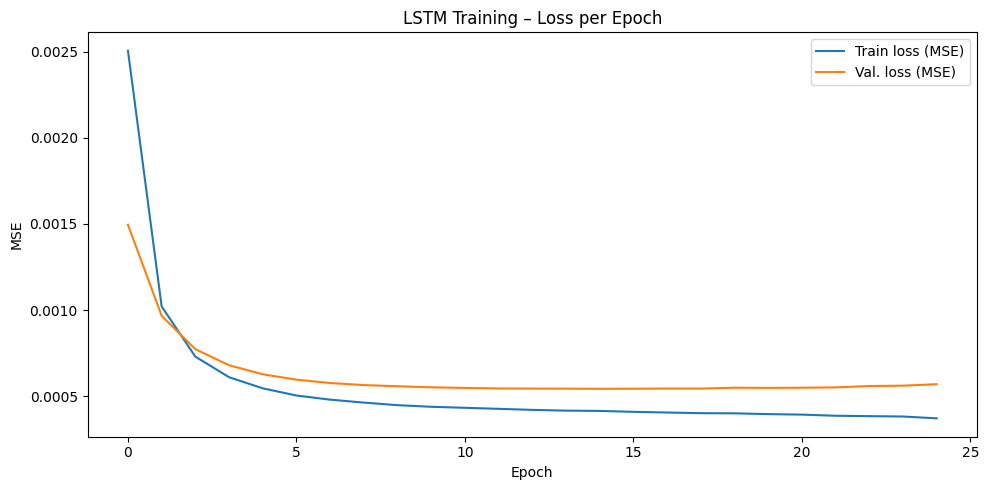

In [17]:
# =========================
# LSTM one-shot portfolio 
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Try to import TensorFlow/Keras ---
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, callbacks, optimizers
except Exception as e:
    raise ImportError(
        "TensorFlow/Keras not available. Please install a compatible version, e.g.\n"
        "  pip install tensorflow\n"
        "and restart the kernel.\n\n"
        f"Original import error: {e}"
    )

# ---- Hyperparameters ----
LOOKBACK = 50          # days of history per training sample
EPOCHS   = 150
BATCH    = 64
VAL_SPL  = 0.2
SEED     = 42

tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ---- Standardize inputs using train statistics (per asset) ----
R_tr  = retn_train.values            # [T_train, N]
mu_tr = R_tr.mean(axis=0)            # per-asset mean (daily)
sd_tr = R_tr.std(axis=0)
sd_tr[sd_tr == 0] = 1e-8             # avoid divide-by-zero
R_tr_z = (R_tr - mu_tr) / sd_tr

# Ensure N is defined
N = retn_train.shape[1]

# ---- Build supervised dataset: X=(lookback,N), y=next-day returns (raw, not z) ----
def make_xy(Rz_input, R_target, L):
    X, y = [], []
    T = Rz_input.shape[0]
    for t in range(L, T):
        X.append(Rz_input[t-L:t, :])
        y.append(R_target[t, :])     # raw daily return at t
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

Xtr, ytr = make_xy(R_tr_z, R_tr, LOOKBACK)    # shapes: [S, L, N], [S, N]

# ---- LSTM model (multi-output regression: next-day return per asset) ----
model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, N)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.30),
    layers.LSTM(32),
    layers.Dense(N, activation="linear"),  # linear output
])
model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    Xtr, ytr,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL_SPL,
    verbose=0,
    callbacks=[es]
)

# ---- One-shot forecast at test start: use last LOOKBACK days from training only ----
X0 = ((retn_train.values[-LOOKBACK:] - mu_tr) / sd_tr)[None, ...].astype(np.float32)   # [1, L, N]
pred_next = model.predict(X0, verbose=0)[0]   # [N] predicted next-day returns (daily)

# ---- Map forecast to long-only weights with 5% cap (same projector as MV) ----
raw = np.clip(pred_next, 0, None)  # keep only positive alpha
if raw.sum() <= 1e-12:
    # fallback: pick top-10 forecasts (non-negative) to avoid all-zero
    k = min(10, N)
    idx = np.argsort(pred_next)[-k:]
    raw = np.zeros(N); raw[idx] = np.clip(pred_next[idx], 0, None)

w_lstm = project_capped_simplex(raw, CAP_PER_ASSET)

# ---- Wealth paths & stats (same conventions as MV/CVaR) ----
active_lstm = int(np.sum(w_lstm > 1e-9))
W0_lstm     = INITIAL_WEALTH - active_lstm*ASSET_FIXED_COST

rp_lstm_train = (retn_train @ w_lstm).rename("LSTM")
rp_lstm_test  = (retn_test  @ w_lstm).rename("LSTM")
rp_lstm_full  = (retn       @ w_lstm).rename("LSTM")

def _ann_stats(r):
    mu = r.mean()*252.0
    vol = r.std()*np.sqrt(252.0)
    sr = mu/vol if vol>0 else np.nan
    dd = ((1+r).cumprod() / (1+r).cumprod().cummax() - 1.0).min()
    return mu, vol, sr, float(dd)

mu_lstm_in,  sig_lstm_in,  sr_lstm_in,  mdd_lstm_in  = _ann_stats(rp_lstm_train)
mu_lstm_out, sig_lstm_out, sr_lstm_out, mdd_lstm_out = _ann_stats(rp_lstm_test)
mu_lstm_full,sig_lstm_full,sr_lstm_full,mdd_lstm_full= _ann_stats(rp_lstm_full)

wealth_lstm_train_eur = INITIAL_WEALTH * (1 + rp_lstm_train).cumprod()
wealth_lstm_test_eur  = W0_lstm       * (1 + rp_lstm_test ).cumprod()
wealth_lstm_full_eur  = INITIAL_WEALTH * (1 + rp_lstm_full).cumprod()

# ---- Drawdowns (full, no costs) for plotting with EW/MV/CVaR ----
dd_lstm_full = wealth_lstm_full_eur / wealth_lstm_full_eur.cummax() - 1.0

# =========================
# PLOTS: add LSTM to the existing ones
# =========================
# TRAIN
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_train_eur.rename("Equal-Weight (Train)").plot(ax=ax)
wealth_mv_train_eur.rename(f"MV (Train, γ*={best_gamma:.3g})").plot(ax=ax)
wealth_cvar_train_eur.rename(f"CVaR (Train, α={ALPHA:.2f})").plot(ax=ax)
wealth_lstm_train_eur.rename("LSTM (Train)").plot(ax=ax)
ax.set_title("TRAIN Cumulative Wealth (€) — EW vs MV vs CVaR vs LSTM")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend(); plt.tight_layout(); plt.show()

# TEST
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_test_eur.rename(f"Equal-Weight (Test, active={active_eq})").plot(ax=ax)
wealth_mv_test_eur.rename(f"MV (Test, γ*={best_gamma:.3g}, active={active_mv})").plot(ax=ax)
wealth_cvar_test_eur.rename(f"CVaR (Test, α={ALPHA:.2f}, active={active_cvar})").plot(ax=ax)
wealth_lstm_test_eur.rename(f"LSTM (Test, active={active_lstm})").plot(ax=ax)
ax.set_title(f"TEST Cumulative Wealth (€) — One-shot €{INITIAL_WEALTH:,.0f} (–€1 per active asset)")
ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)"); ax.legend(); plt.tight_layout(); plt.show()

# FULL (no costs)
fig, ax = plt.subplots(figsize=(12,6))
wealth_eq_full_eur.rename("Equal-Weight (Full, no costs)").plot(ax=ax)
wealth_mv_full_eur.rename(f"MV (Full, γ*={best_gamma:.3g}, no costs)").plot(ax=ax)
wealth_cvar_full_eur.rename(f"CVaR (Full, α={ALPHA:.2f}, no costs)").plot(ax=ax)
wealth_lstm_full_eur.rename("LSTM (Full, no costs)").plot(ax=ax)
ax.axvline(retn_test.index[0], linestyle="--", label="Test start")
ax.set_title("FULL Cumulative Wealth (€) — EW vs MV vs CVaR vs LSTM"); ax.set_xlabel("Date"); ax.set_ylabel("Wealth (€)")
ax.legend(); plt.tight_layout(); plt.show()

# =========================
# TABLES: append LSTM row idempotently
# =========================
summary_train.loc["LSTM", ["Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    mu_lstm_in, sig_lstm_in, sr_lstm_in, mdd_lstm_in
]
summary_test.loc["LSTM", ["ActiveAssets","UpfrontCost(€)","InitialNet(€)",
                          "FinalWealth(€)","Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    active_lstm, active_lstm*ASSET_FIXED_COST,
    INITIAL_WEALTH - active_lstm*ASSET_FIXED_COST,
    float(wealth_lstm_test_eur.iloc[-1]),
    mu_lstm_out, sig_lstm_out, sr_lstm_out, mdd_lstm_out
]
summary_full.loc["LSTM", ["Ann.Return","Ann.Vol","Sharpe","MaxDD"]] = [
    mu_lstm_full, sig_lstm_full, sr_lstm_full, mdd_lstm_full
]

try:
    show(summary_train, "Portfolio — TRAIN (EW vs MV vs CVaR vs LSTM)")
    show(summary_test,  "Portfolio — TEST (EW vs MV vs CVaR vs LSTM)")
    show(summary_full,  "Portfolio — FULL WINDOW (EW vs MV vs CVaR vs LSTM)")
except Exception:
    print("Summary tables displayed with print/display fallback.")
    display(summary_train); display(summary_test); display(summary_full)

# =========================
# WEIGHTS TABLE: LSTM
# =========================
lstm_weights = pd.DataFrame({"Instrument": prices_100.columns, "Weight": w_lstm}) \
                   .sort_values("Weight", ascending=False)
lstm_weights = lstm_weights[lstm_weights["Weight"] > 1e-6]
print(f"LSTM One‑shot Weights (active={active_lstm})"); display(lstm_weights)
lstm_weights.to_csv("lstm_weights_vector.csv", index=False)

# ============================================================
# LSTM – ADD-ONS: training curve, iterative forecasts, error stats
# (Non-invasive: does not alter existing plots/tables)
# ============================================================

# --- 1) Training history plot (loss & val_loss) ---
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history.history.get("loss", []), label="Train loss (MSE)")
ax.plot(history.history.get("val_loss", []), label="Val. loss (MSE)")
ax.set_title("LSTM Training – Loss per Epoch")
ax.set_xlabel("Epoch"); ax.set_ylabel("MSE"); ax.legend()
plt.tight_layout(); plt.show()

# --- 2) Helper: open-loop rolling forecast with actuals (production-style) ---
def rolling_forecast_with_actuals(model, retn_oo, retn_hist, mu_tr, sd_tr, lookback):
    """
    retn_oo   : DataFrame of out-of-sample realized returns (index ascending)
    retn_hist : DataFrame immediately preceding retn_oo (to seed LOOKBACK window)
    mu_tr, sd_tr: 1D arrays with per-asset train mean/std
    Returns:
        preds_df : DataFrame of model's next-day predictions aligned to retn_oo.index
    """
    # Seed window with last LOOKBACK days of historical returns (raw)
    win_hist = retn_hist.values[-lookback:]                                  # [L, N]
    X = ((win_hist - mu_tr) / sd_tr).astype(np.float32)[None, ...]           # [1, L, N]

    dates = []
    preds = []
    for dt, y_act in retn_oo.iterrows():
        # Predict next-day (raw, not z-scored)
        y_hat = model.predict(X, verbose=0)[0]                                # [N]
        dates.append(dt); preds.append(y_hat.copy())

        # Update window with the ACTUAL realized return at dt (normalized)
        y_act = y_act.values.astype(np.float32)
        y_act_norm = (y_act - mu_tr) / sd_tr
        X[:, :-1, :] = X[:, 1:, :]
        X[:, -1,  :] = y_act_norm

    preds_df = pd.DataFrame(np.vstack(preds), index=dates, columns=retn_oo.columns)
    return preds_df

# Build the historical segment that ends exactly the day before test starts
_retn_hist = retn.loc[: retn_test.index[0]].iloc[:-1]
preds_open = rolling_forecast_with_actuals(
    model=model,
    retn_oo=retn_test,
    retn_hist=_retn_hist,
    mu_tr=mu_tr,
    sd_tr=sd_tr,
    lookback=LOOKBACK
)
preds_open.to_csv("lstm_iterative_open_loop_predictions.csv")

# --- 3) (Optional) Closed-loop scenario path (no actuals; error compounds) ---
def recursive_forecast_closed_loop(model, X0, mu_tr, sd_tr, horizon):
    """
    X0      : np.array [1, LOOKBACK, N] normalized (the same you used above)
    horizon : number of steps to simulate forward
    Returns:
        preds : np.array [horizon, N] raw returns (model-generated)
    """
    mu = mu_tr.astype(np.float32); sd = sd_tr.astype(np.float32)
    X = X0.astype(np.float32).copy()
    preds = np.zeros((horizon, X.shape[-1]), dtype=np.float32)
    for h in range(horizon):
        y_hat = model.predict(X, verbose=0)[0]      # raw
        preds[h] = y_hat
        X[:, :-1, :] = X[:, 1:, :]
        X[:, -1,  :] = ((y_hat - mu) / sd)
    return preds

H = min(len(retn_test), 504)  # cap at ~2Y or test length, whichever is smaller
preds_closed = recursive_forecast_closed_loop(model, X0, mu_tr, sd_tr, H)
preds_closed = pd.DataFrame(preds_closed, index=retn_test.index[:H], columns=retn_test.columns)
preds_closed.to_csv("lstm_closed_loop_scenario_predictions.csv")

# --- 4) Prediction error statistics (open-loop, comparable to realized) ---
err_open = preds_open.reindex_like(retn_test) - retn_test

# Per-asset metrics
ss_res = (err_open ** 2).sum(axis=0)
ss_tot = ((retn_test - retn_test.mean(axis=0)) ** 2).sum(axis=0)
r2_per_asset = 1.0 - (ss_res / ss_tot.replace(0.0, np.nan))

sign_match = (np.sign(preds_open) == np.sign(retn_test)) & (retn_test != 0.0)
hit_rate_per_asset = sign_match.sum(axis=0) / (~retn_test.eq(0.0)).sum(axis=0)

per_asset_errors = pd.DataFrame({
    "MAE": err_open.abs().mean(axis=0),
    "RMSE": np.sqrt((err_open ** 2).mean(axis=0)),
    "R2": r2_per_asset,
    "HitRate": hit_rate_per_asset
}).sort_index()

# Overall metrics (macro-averaged across assets)
overall_errors = pd.Series({
    "MAE": per_asset_errors["MAE"].mean(),
    "RMSE": per_asset_errors["RMSE"].mean(),
    "R2": per_asset_errors["R2"].mean(),
    "HitRate": per_asset_errors["HitRate"].mean()
}, name="Overall")

# Persist and display via your helper `show`
overall_errors.to_frame().to_csv("lstm_prediction_errors_overall.csv")


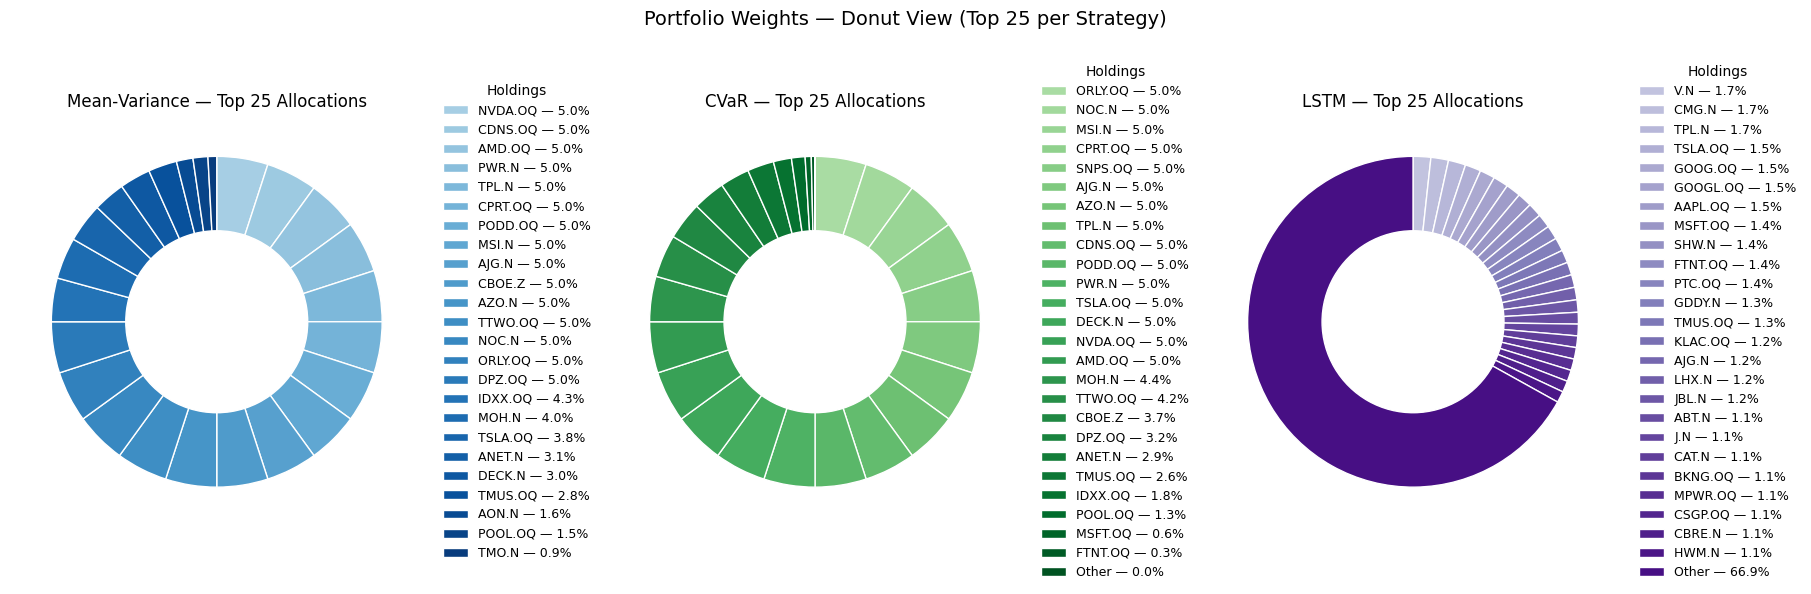

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- config ----------
FILES = {
    "Mean‑Variance": "mv_weights_vector.csv",
    "CVaR":          "cvar_weights_vector.csv",
    "LSTM":          "lstm_weights_vector.csv",
}
TOPK       = 25     # show top-25 slices, aggregate the rest as "Other"
LEG_FONTSZ = 9
CMAPS      = [plt.cm.Blues, plt.cm.Greens, plt.cm.Purples]  # distinct palettes

def _topk_with_other(df, topk=TOPK):
    df = df.sort_values("Weight", ascending=False).reset_index(drop=True)
    if len(df) > topk:
        other_w = df.loc[topk:, "Weight"].sum()
        df = df.iloc[:topk, :].copy()
        df.loc[len(df)] = {"Instrument": "Other", "Weight": other_w}
    return df

def _labels_with_pct(df):
    # Legend labels like "NVDA.OQ — 5.0%"
    pct = 100 * df["Weight"] / df["Weight"].sum()
    return [f"{i} — {p:.1f}%" for i, p in zip(df["Instrument"], pct)]

def _colors_from_cmap(cmap, n):
    # lighter center → darker perimeter (nice gradient)
    return [cmap(0.35 + 0.6 * (i/(n-1))) for i in range(n)]

# ---------- build figure ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, (title, fname), cmap in zip(axes, FILES.items(), CMAPS):
    df = pd.read_csv(fname)
    df = _topk_with_other(df, TOPK)

    # colors + no wedge labels
    colors = _colors_from_cmap(cmap, len(df))
    wedges, _ = ax.pie(
        df["Weight"].values,
        labels=None,                       # <-- no text around donut
        startangle=90,
        counterclock=False,
        colors=colors,
        wedgeprops=dict(width=0.45, edgecolor="white")
    )

    ax.set_title(f"{title} — Top {TOPK} Allocations", fontsize=12)
    ax.set_aspect("equal")

    # legend on the side with "Ticker — x.x%" entries
    leg_labels = _labels_with_pct(df)
    # put the legend outside (right) of each subplot
    ax.legend(
        wedges, leg_labels, title="Holdings",
        loc="center left", bbox_to_anchor=(1.02, 0.5),
        frameon=False, fontsize=LEG_FONTSZ, title_fontsize=LEG_FONTSZ+1
    )

# Optional global title
fig.suptitle("Portfolio Weights — Donut View (Top 25 per Strategy)", fontsize=14, y=1.02)
plt.show()
